In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from tensorflow.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import TensorBoard
from time import time

In [3]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('deeplearning_check.py','wb').write(src)



Saving deeplearning_check.py to deeplearning_check.py


7670

In [4]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('basic_preprocessing.py','wb').write(src)

Saving basic_preprocessing.py to basic_preprocessing.py


5023

In [5]:
from google.colab import files 
src = list(files.upload().values())[0] 
open('machine_learning.py','wb').write(src)

Saving machine_learning.py to machine_learning.py


5283

In [6]:
!pip install split_folders

In [7]:
from basic_preprocessing import *
from deeplearning_check import *
from machine_learning import *

gpu_check()
set_global_determinism(seed=SEED)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 596885489349468849
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11345264640
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12354164913697923402
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"
]
tf 2.6.0
keras 2.6.0
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라
set_global_determinism(seed=1337) 이거 꼭 해라


In [8]:
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

#### basic model

In [9]:
set_global_determinism(seed=1337)

In [10]:
train_dir = '/content/drive/MyDrive/Sign Detection/Datasets/Stratified/train'
test_dir = '/content/drive/MyDrive/Sign Detection/Datasets/Stratified/test'
val_dir = '/content/drive/MyDrive/Sign Detection/Datasets/Stratified/val'

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
from keras import Input
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(200,200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(200, 200), color_mode='rgb')
test_generator = test_datagen.flow_from_directory(test_dir,batch_size=16, target_size=(200, 200), color_mode='rgb')

input_tensor = Input(shape=(200, 200, 3), dtype='float32', name='input')

Found 390 images belonging to 4 classes.
Found 123 images belonging to 4 classes.
Found 97 images belonging to 4 classes.


#### model creating

In [13]:
def create_model():
    optimizer = optimizers.SGD(lr= 0.001, decay = 1e-6, momentum= 0.9, nesterov=True)
    
    pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    #include_top FC 레이어 포함유무 결정
    #feature extraction 파라미터들은 이미지넷으로 학습된 값들을 그대로 사용할 것이기 때문에 trainable의 속성을 False
    pre_trained_vgg.trainable = False
    additional_model = tf.keras.Sequential()
    additional_model.add(pre_trained_vgg)
    additional_model.add(Flatten())
    additional_model.add(tf.keras.layers.Dense(4096, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(2048, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(1024, activation='relu'))
    additional_model.add(tf.keras.layers.Dense(4, activation='softmax'))
    

    additional_model.compile(optimizer = optimizer, loss = keras.losses.categorical_crossentropy, metrics=['acc'])

    
    return additional_model

In [14]:
# 모델 실행 옵션 
model = create_model()
model.summary()


58900480/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 4100      
Total params: 100,709,188
Trainable params: 85,994,500
No

In [15]:
checkpoint_path = "check_point/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [16]:
#모델의 가중치 저장
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
            monitor='loss', 
            mode='min',
            save_best_only=True,
            save_weights_only=True,
            verbose=1)

#새로운 콜백으로 모델 훈련하기
history = model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=100, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint],
            shuffle=False)

Epoch 1/100
25/25 [==============================] - 144s 5s/step - loss: 0.8977 - acc: 0.6641 - val_loss: 0.5716 - val_acc: 0.8374

Epoch 00001: loss improved from inf to 0.89774, saving model to check_point/cp.ckpt
Epoch 2/100
25/25 [==============================] - 6s 226ms/step - loss: 0.3130 - acc: 0.9051 - val_loss: 0.2332 - val_acc: 0.9187

Epoch 00002: loss improved from 0.89774 to 0.31304, saving model to check_point/cp.ckpt
Epoch 3/100
25/25 [==============================] - 6s 225ms/step - loss: 0.1633 - acc: 0.9667 - val_loss: 0.2406 - val_acc: 0.9431

Epoch 00003: loss improved from 0.31304 to 0.16332, saving model to check_point/cp.ckpt
Epoch 4/100
25/25 [==============================] - 6s 225ms/step - loss: 0.1504 - acc: 0.9487 - val_loss: 0.1495 - val_acc: 0.9512

Epoch 00004: loss improved from 0.16332 to 0.15040, saving model to check_point/cp.ckpt
Epoch 5/100
25/25 [==============================] - 6s 226ms/step - loss: 0.0957 - acc: 0.9821 - val_loss: 0.1449 - 

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


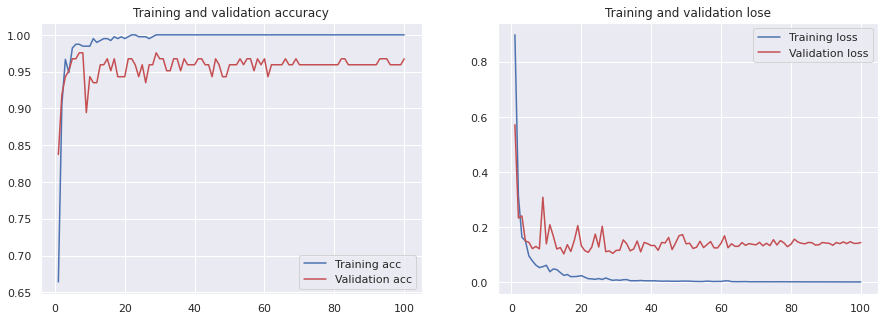

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) +1)
    
    

fig = plt.figure()
fig.set_size_inches(15, 5)

fig.add_subplot(1, 2, 1)
plt.plot(epochs, acc, 'b', label ='Training acc')
plt.plot(epochs, val_acc, 'r', label = 'Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

# plt.figure()
fig.add_subplot(1, 2, 2) 
plt.plot(epochs, loss, 'b', label = "Training loss")
plt.plot(epochs, val_loss, 'r', label ='Validation loss')
plt.title('Training and validation lose')
plt.legend()

plt.show()

In [18]:
#맥에서는 !ls
#저장된 checkpoint확인하기
!dir {checkpoint_dir}

checkpoint  cp.ckpt.data-00000-of-00001  cp.ckpt.index


In [19]:
#가장 마지막에 만들어진 체크포인트 확인
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'check_point/cp.ckpt'

In [20]:
# 기본 모델 객체를 만듭니다
model = create_model()

# 모델을 평가합니다
loss, acc = model.evaluate(val_generator, verbose=2)
print("훈련되지 않은 모델의 정확도: {:5.2f}%".format(100*acc))

8/8 - 2s - loss: 1.5490 - acc: 0.1626
훈련되지 않은 모델의 정확도: 16.26%


In [21]:
# 가중치 로드
model.load_weights(latest)

# # 모델 재평가
loss,acc = model.evaluate(val_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

8/8 [==============================] - 1s 150ms/step - loss: 0.1439 - acc: 0.9675
복원된 모델의 정확도: 96.75%


In [22]:
# # 모델 재평가
loss,acc = model.evaluate(test_generator)
print("복원된 모델의 정확도: {:5.2f}%".format(100*acc))

7/7 [==============================] - 20s 3s/step - loss: 0.1709 - acc: 0.9175
복원된 모델의 정확도: 91.75%


#### final model save

In [23]:
model.save('[0921]stratified_4class_v2.h5')

model_json = model.to_json()
with open("[0921]stratified_4class_v2.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("[0921]stratified_4class_v2_weight.h5")
print("Saved model to disk")

Saved model to disk


In [24]:
label_dict = get_label_dict(train_generator)
label_dict

{0: 'fragile', 1: 'handle', 2: 'up', 3: 'wet'}

### Test

#### validation set

In [25]:
def multi_get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred, average = 'micro')
    recall = recall_score(y_test , pred, average = 'micro')
    f1 = f1_score(y_test,pred, average = 'micro')
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred, multi_class='ovr')
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    return confusion

[3 0 2 0 3 3 1 2 0 2 1 0 0 1 0 1 2 2 3 0 3 0 0 1 1 2 3 0 0 3 0 3 2 1 2 0 2
 2 2 2 2 2 0 0 0 3 0 2 3 2 0 0 2 1 2 0 1 0 0 2 0 0 2 2 0 3 1 0 1 2 0 2 2 3
 1 0 0 3 2 0 1 1 3 0 0 0 3 2 2 2 0 0 0 0 1 0 1 0 3 0 0 1 1 0 0 2 1 3 3 2 3
 3 2 3 3 0 0 0 0 2 2 3 0]
Confusion Matrix
[[17  7 16 10]
 [ 9  4  5  1]
 [14  5  7  5]
 [ 8  3  5  7]]
              precision    recall  f1-score   support

     fragile       0.35      0.34      0.35        50
      handle       0.21      0.21      0.21        19
          up       0.21      0.23      0.22        31
         wet       0.30      0.30      0.30        23

    accuracy                           0.28       123
   macro avg       0.27      0.27      0.27       123
weighted avg       0.29      0.28      0.29       123



<Figure size 432x432 with 0 Axes>

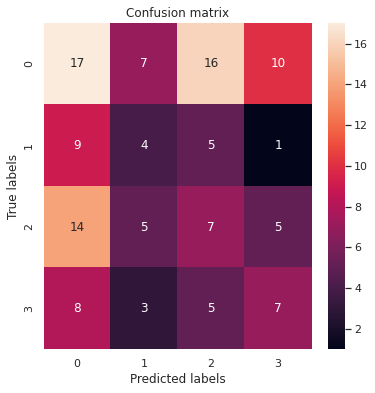

In [26]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(val_generator.samples / val_generator.batch_size)


predictions = model.predict_generator(val_generator, steps=test_steps_per_epoch)

# Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

print(predicted_classes)
# 2.Get ground-truth classes and class-labels
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())   
# 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, predicted_classes))
print(report)

plt.figure(figsize=(6,6))
con_test = confusion_matrix(val_generator.classes, predicted_classes)
confusion_plot(con_test, 6)


#### test set

In [27]:
test_generator.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3], dtype=int32)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Confusion Matrix
[[17  7 13  3]
 [ 3  2  5  5]
 [15  3  2  5]
 [ 6  4  5  2]]
              precision    recall  f1-score   support

     fragile       0.41      0.42      0.42        40
      handle       0.12      0.13      0.13        15
          up       0.08      0.08      0.08        25
         wet       0.13      0.12      0.12        17

    accuracy                           0.24        97
   macro avg       0.19      0.19      0.19        97
weighted avg       0.23      0.24      0.24        97



<Figure size 432x432 with 0 Axes>

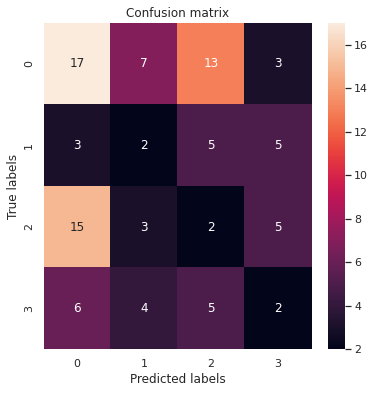

In [31]:
#confusion matrix
from sklearn.metrics import confusion_matrix

# 1.Predict classes
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)


predictions = model.predict_generator(test_generator, steps=test_steps_per_epoch)
# print(predictions)
# # Get most likely class axis=1(열로 가장 큰 수의 위치를 보겠다는 소리), 
predicted_classes = np.argmax(predictions, axis=1)

# print(predicted_classes)
# # 2.Get ground-truth classes and class-labels
true_classes = test_generator.classes
print(true_classes)
class_labels = list(test_generator.class_indices.keys())   
# # 3. Use scikit-learn to get statistics
report = classification_report(true_classes, predicted_classes, target_names=class_labels)


print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, predicted_classes))
print(report)

plt.figure(figsize=(6,6))
con_test = confusion_matrix(test_generator.classes, predicted_classes)
confusion_plot(con_test, 6)


In [29]:
results = model.evaluate(test_generator, batch_size=16)
print('test loss, test acc: ', results)

7/7 [==============================] - 1s 132ms/step - loss: 0.1709 - acc: 0.9175
test loss, test acc:  [0.17093491554260254, 0.9175257682800293]


In [30]:
def prepare_image_for_prediction( img):
   
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    # The below function inserts an additional dimension at the axis position provided
    img = np.expand_dims(img, axis=0)
    # perform pre-processing that was done when resnet model was trained.
    return preprocess_input(img)

In [ ]:
file_list = get_file_list('/content/drive/MyDrive/Sign Detection/ML/test/')
print(len(file_list))

In [ ]:
file_list = file_list[1:]

In [ ]:
img_list=[]
for i in file_list:
    img = cv2.imread(i, cv2.IMREAD_COLOR)
    input_img = prepare_image_for_prediction(img)
    img_list.append(input_img)


In [ ]:
predicted_class = []

for i in img_list:
    pred_vec = model.predict(i)
    confidence = np.round(pred_vec.max(),2)
    pc = pred_vec.argmax()
    predicted_class.append(pc)

In [ ]:
answer_test = []

for i in file_list:
    if 'fragile' in i:
        answer_test.append('0')
    elif 'up_resized' in i:
        answer_test.append('2')
    elif 'handle_resized' in i :
        answer_test.append('1')
    elif 'wet_resized' in i :
        answer_test.append('3')
    else :
        answer_test.append(i)

In [ ]:
print(len(file_list))
print(len(answer_test))
print(len(predicted_class))

In [ ]:

answer = []
for i in answer_test:
    i = int(i)
    answer.append(i)

In [ ]:
prediction = []
for i in predicted_class:
    i = int(i)
    prediction.append(i)

In [ ]:
print(accuracy_score(answer, prediction))
print(recall_score(answer, prediction, average='weighted'))
print(precision_score(answer, prediction, average='micro'))
print(f1_score(answer, prediction, average='macro'))

In [ ]:
conf= confusion_matrix(answer, prediction)
confusion_plot(conf,6)